In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

plt.rcParams['figure.figsize'] = (16, 10)
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [3]:
# Create the environment
env = gym.make("LunarLander-v2")
# env = gym.make("CartPole-v1") 
states_length = env.observation_space.shape[0]
n_actions = env.action_space.n

policy_nn = PolicyNetwork(state_size=states_length,
                          action_size=n_actions, 
                          hidden_size=32).to(device)
optimizer = optim.Adam(policy_nn.parameters(), lr=1e-2)
gamma = 0.99
eps = np.finfo(np.float32).eps.item()

max_episode = 10000
max_steps_per_episode = 1000
scores = deque(maxlen=max_episode)
running_reward = 0

for e in range(1, max_episode): # iterate untile solution (see below)
    state, _ = env.reset()
    episode_reward = 0
    saved_log_probs = []
    rewards = []

    # Collect trajectory
    for t in range(1, max_steps_per_episode+1):
        # Sample the action from current policy
        action, log_prob = policy_nn.select_action(state)
        state, reward, done, _, _ = env.step(action)
        saved_log_probs.append(log_prob)
        rewards.append(reward)
        episode_reward += reward
        if done:
            break
    
    scores.append(episode_reward)
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

    G = 0
    policy_loss = []
    returns = deque()
    for r in rewards[::-1]:
        G = r + gamma * G
        returns.appendleft(G)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for log_prob, rew in zip(saved_log_probs, returns):
        policy_loss.append(-log_prob * rew)
    
    # Backpropagation
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()

    del saved_log_probs
    del rewards
    
    if e % 10 == 0:
        print(f"Reward at {e} episode: {running_reward:.2f}")
    if running_reward >= 250: #termination condition
        print(f"Solved at {e} episode: score={running_reward}")
        break

torch.save(policy_nn.state_dict(), "checkpoints/moon_lander.pt")

Reward at 10 episode: -85.50
Reward at 20 episode: -128.39
Reward at 30 episode: -130.81
Reward at 40 episode: -148.99
Reward at 50 episode: -144.74
Reward at 60 episode: -161.82
Reward at 70 episode: -133.97
Reward at 80 episode: -115.76
Reward at 90 episode: -102.01
Reward at 100 episode: -93.00
Reward at 110 episode: -103.56
Reward at 120 episode: -100.18
Reward at 130 episode: -113.29
Reward at 140 episode: -91.46
Reward at 150 episode: -77.72
Reward at 160 episode: -84.07
Reward at 170 episode: -71.76
Reward at 180 episode: -58.39
Reward at 190 episode: -53.70
Reward at 200 episode: -71.13
Reward at 210 episode: -85.67
Reward at 220 episode: -88.41
Reward at 230 episode: -77.01
Reward at 240 episode: -67.18
Reward at 250 episode: -72.51
Reward at 260 episode: -79.69
Reward at 270 episode: -66.15
Reward at 280 episode: -48.35
Reward at 290 episode: -39.92
Reward at 300 episode: -75.76
Reward at 310 episode: -40.12
Reward at 320 episode: -25.88
Reward at 330 episode: -12.35
Reward a

KeyboardInterrupt: 

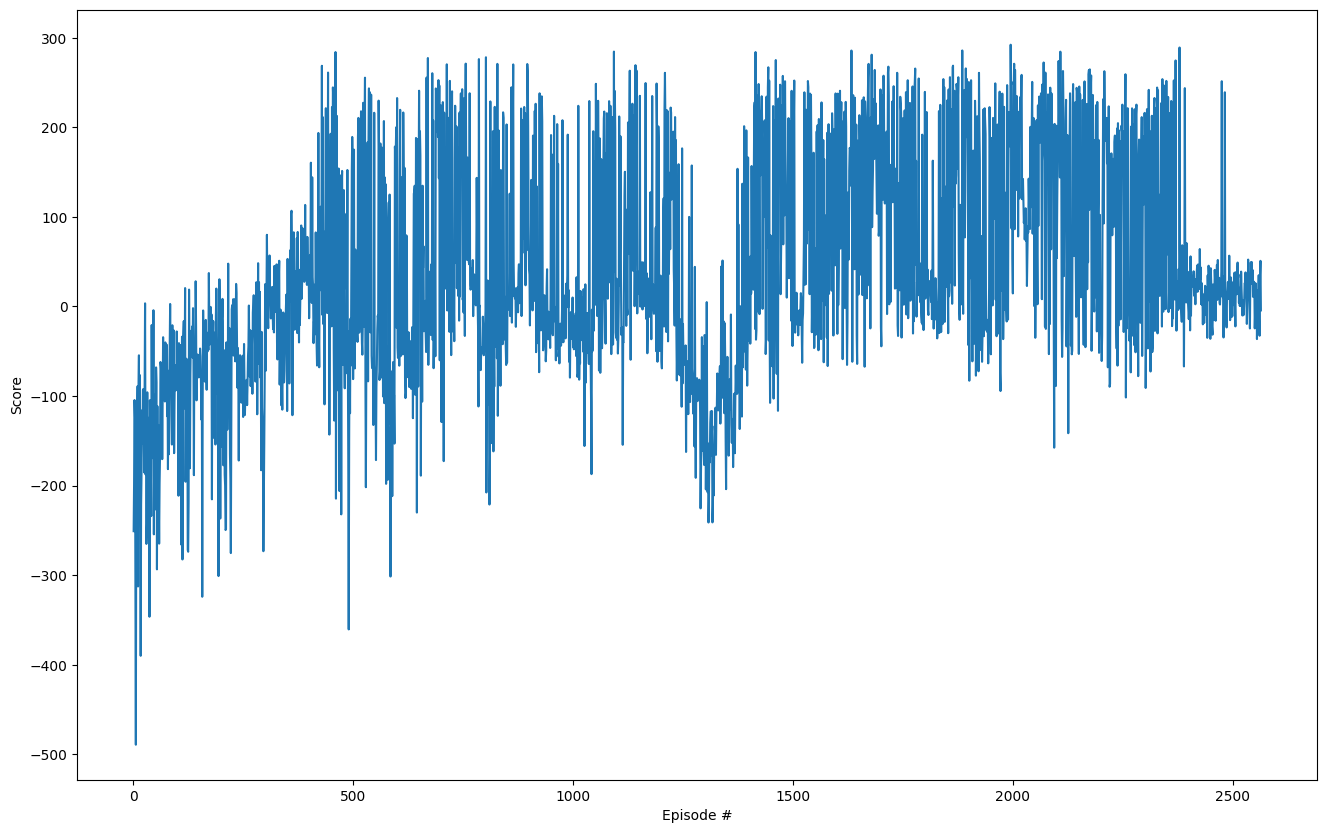

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [5]:
env = gym.make("LunarLander-v2", render_mode="human")

state, _ = env.reset()
done = False
for t in range(1000):
    action, _ = policy_nn.select_action(state)
    next_state, reward, done, _, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()